In [29]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
r = pd.read_csv("rmsg_comm.csv")
r

/tmp/ipykernel_20189/956506028.py:1: DtypeWarning: Columns (27,30) have mixed types. Specify dtype option on import or set low_memory=False.
  r = pd.read_csv("rmsg_comm.csv")


,chat_id,id,chat_name,peer_id,messagedatetime,messagedate,messagetext,out,mentioned,media_unread,...,post_author,grouped_id,ttl_period,quick_reply_shortcut_id,effect,factcheck,views,forwards,replies,reactions
0,1872871388,4988378,https://t.me/specchatZ,1872871388,2024-12-08 11:00:06,2024-12-08,Гнида приехала лизать дупу трампу,f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
1,1872871388,4988380,https://t.me/specchatZ,1872871388,2024-12-08 11:00:55,2024-12-08,"Да, как все быстро устроили🙈🙈🙈🙈",f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
2,1872871388,4988384,https://t.me/specchatZ,1872871388,2024-12-08 11:01:13,2024-12-08,⚡️ Правила чата:\n\n⚠️ Ссылки и пересылки из д...,f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
3,1872871388,4988385,https://t.me/specchatZ,1872871388,2024-12-08 11:02:02,2024-12-08,Смирись и прими!\nКаждому своё время!,f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
4,1872871388,4988386,https://t.me/specchatZ,1872871388,2024-12-08 11:02:05,2024-12-08,Украину давно желают🙈🙈🙈🙈😡😡😡,f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3048941,1366415996,19037272,https://t.me/readovchat,1366415996,2024-12-16 09:16:14,2024-12-16,"Раньше отстреливали всех и все, зверье зало, ч...",f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
3048942,1366415996,19037278,https://t.me/readovchat,1366415996,2024-12-16 09:16:27,2024-12-16,"Знаю несколько пар, которые не заводят детей т...",f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,"{""👍"": 1}"
3048943,1366415996,19037285,https://t.me/readovchat,1366415996,2024-12-16 09:16:38,2024-12-16,Жилищный вопрос - это только часть проблемы. Я...,f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,"{""❤"": 2, ""🤯"": 1}"
3048944,1366415996,19037298,https://t.me/readovchat,1366415996,2024-12-16 09:17:30,2024-12-16,Но от таджиков и негров рожают. Значит нашим м...,f,f,f,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN


In [18]:
def organize_threads(csv_file_path):
    # First pass: read all messages and create message lookup
    messages = {}
    roots = []

    with open(csv_file_path, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            msg_id = row['id']
            chat_id = row['chat_id']
            reply_to = row['reply_to']

            # Create composite key using both chat_id and msg_id
            msg_key = f"{chat_id}_{msg_id}"

            messages[msg_key] = {
                'data': row,
                'children': []
            }

            # If it's a root message (no reply_to)
            if not reply_to:
                roots.append(msg_key)

    # Second pass: build threads by connecting replies
    for msg_key, msg_data in messages.items():
        reply_to = msg_data['data']['reply_to']
        chat_id = msg_data['data']['chat_id']

        if reply_to:
            # Create parent message key using the same chat_id
            parent_key = f"{chat_id}_{reply_to}"
            if parent_key in messages:
                messages[parent_key]['children'].append(msg_key)

    # Helper function to flatten a thread
    def flatten_thread(msg_key):
        thread = [messages[msg_key]['data']]
        for child_key in messages[msg_key]['children']:
            thread.extend(flatten_thread(child_key))
        return thread

    # Build final list of threads
    threads = []
    for root_key in roots:
        thread = flatten_thread(root_key)
        threads.append(thread)

    return threads


In [19]:
threads = organize_threads('rmsg_comm.csv')

In [20]:
def create_thread_summary_df_optimized(threads):
    thread_summaries = []

    for thread in threads:
        if not thread:
            continue

        root_message = thread[0]
        root_id = root_message['id']

        # Create a message lookup dictionary for this thread
        msg_depths = {root_id: 0}  # Root has depth 0
        max_depth = 0

        # Single pass through messages to calculate depths
        for msg in thread[1:]:  # Skip root message
            reply_to = msg['reply_to']
            if reply_to in msg_depths:
                depth = msg_depths[reply_to] + 1
                msg_depths[msg['id']] = depth
                max_depth = max(max_depth, depth)

        thread_summary = {
            'root_id': root_id,
            'messagetext': root_message.get('messagetext', ''),
            'chat_name': root_message.get('chat_name', ''),
            'thread_size': len(thread),
            'max_depth': max_depth
        }
        thread_summaries.append(thread_summary)

    return pd.DataFrame(thread_summaries)

In [21]:
df = create_thread_summary_df_optimized(threads)
df = df.sort_values('thread_size', ascending=False)
df

,root_id,messagetext,chat_name,thread_size,max_depth
262539,18081366,На М-12 водитель фуры резко перестроился в лев...,https://t.me/readovchat,2777,33
341869,18926209,В Дзержинске школьницы дважды впечатали учител...,https://t.me/readovchat,2489,22
262435,18048844,Жители Химок несколько лет терпят запах гнили ...,https://t.me/readovchat,2437,10
202558,18259811,Проректор Финансового Университета Зубец предл...,https://t.me/readovchat,2266,21
341801,18900319,"Тот самый 14-летний чеченец, за которого накан...",https://t.me/readovchat,2255,26
...,...,...,...,...,...
17,4989729,Полная Нассрала,https://t.me/specchatZ,1,0
16,4989705,"Pondok Indah, вам повышена репутация!🌟\nСейчас...",https://t.me/specchatZ,1,0
14,4994324,"Alesia Astaxova, вам повышена репутация!🌟\nСей...",https://t.me/specchatZ,1,0
13,4989727,Кто насрал,https://t.me/specchatZ,1,0


In [53]:
def plot_thread_density_simple(thread, interval_minutes=10):
    # Clear any existing plots
    plt.clf()

    df = pd.DataFrame(thread)
    df['timestamp'] = pd.to_datetime(df['messagedatetime'])

    counts = df.resample(f'{interval_minutes}min', on='timestamp').size()

    # Create a new figure
    fig = plt.figure(figsize=(15, 7))

    plt.plot(counts.index, counts.values, '-', linewidth=2)

    plt.title(f'Comment Density Over Time\n'
              f'Thread started: {df.timestamp.min().strftime("%Y-%m-%d %H:%M:%S")}\n'
              f'Total messages: {len(thread)}, Interval: {interval_minutes} minutes')

    plt.xlabel('Time')
    plt.ylabel('Number of comments')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()

    # Close the figure to prevent display
    plt.close()

    return fig

In [54]:
sorted_threads = sorted(threads, key=len, reverse=True)

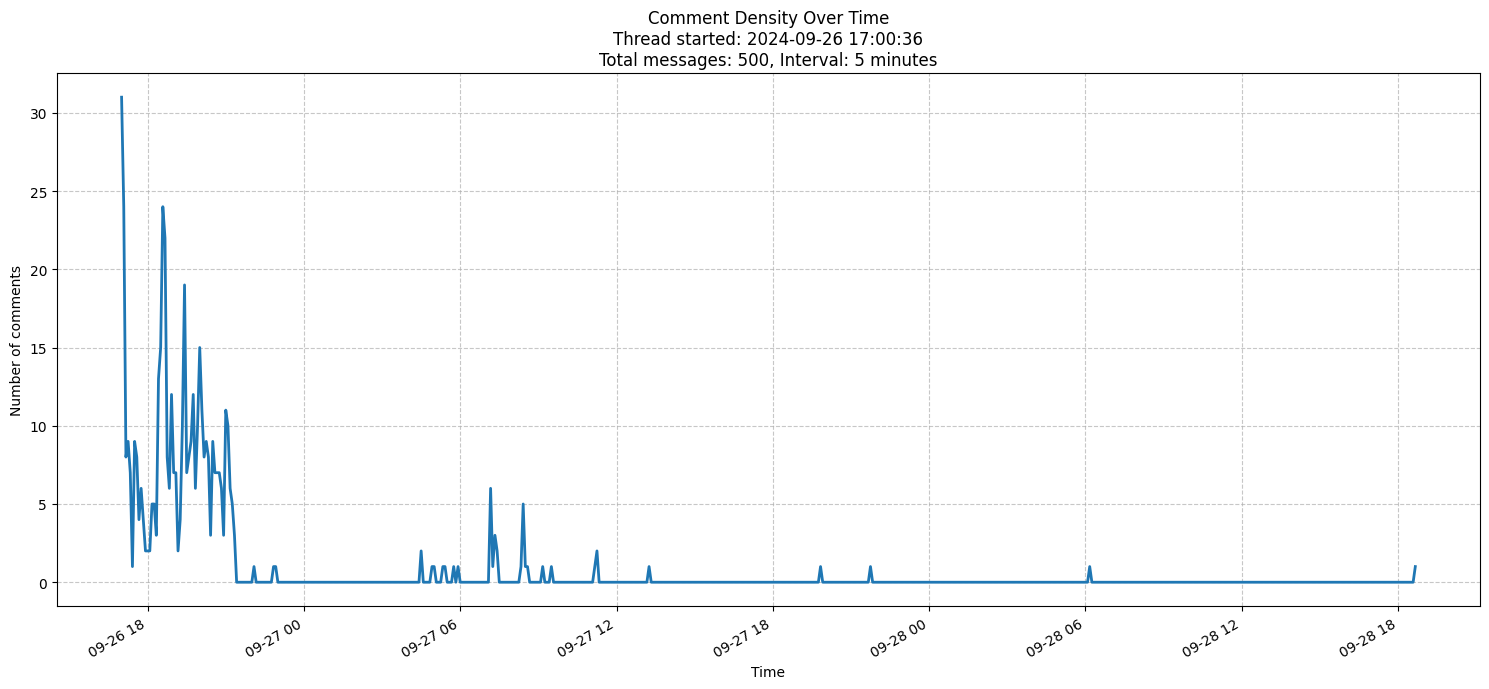

<Figure size 640x480 with 0 Axes>

In [76]:
fig = plot_thread_density_simple(sorted_threads[0][:500], interval_minutes=5)
fig

In [40]:
len(threads[0])

50